<a href="https://colab.research.google.com/github/phudatdam/project-1-image-classification/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments

## Data

### Config

In [ ]:
import torch

INPUT_SIZE = 32
INPUT_CHANNEL = 3
NUM_CLASSES = 10
BATCH_SIZE = 64
TRAIN_PROPORTION = 0.8

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

### Loading

In [ ]:
import torch
from torchvision import datasets

trainval_set = datasets.CIFAR10(root='./data', train=True, download=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


### Preprocessing

In [ ]:
from torch.utils.data import random_split

train_size = int(TRAIN_PROPORTION * len(trainval_set))
val_size = len(trainval_set) - train_size
generator = torch.Generator().manual_seed(SEED)
train_set, val_set = random_split(trainval_set, [train_size, val_size], generator=generator)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [ ]:
import torchvision.transforms as transforms

train_tensor = torch.stack([transforms.ToTensor()(img) for img, _ in train_set], dim=3)
mean = train_tensor.view(train_tensor.shape[0], -1).mean(dim=1)
std = train_tensor.view(train_tensor.shape[0], -1).std(dim=1)

print('Train set mean:', mean)
print('Train set std:', std)

Train set mean: tensor([0.4917, 0.4826, 0.4471])
Train set std: tensor([0.2471, 0.2435, 0.2617])


## Utils

### Create Data Loaders

In [ ]:
from torch.utils.data import DataLoader

def create_data_loaders(input_size):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_set.dataset.transform = transform
    val_set.dataset.transform = transform
    test_set.transform = transform

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

### Model Summary

In [ ]:
!pip install torchinfo

### Training

In [ ]:
import time
import torch

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    epoch_time_history = []

    model.to(device)

    for epoch in range(num_epochs):
        # Train
        start_time = time.time()
        model.train()
        running_train_loss = 0.0
        correct_train = total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_time_history.append(epoch_time)

        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validate
        model.eval()
        running_val_loss = 0.0
        correct_val = total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.2f}%, '
              f'Val loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.2f}%, '
              f'Time: {epoch_time:.2f}s')

    average_epoch_time = sum(epoch_time_history) / num_epochs
    print(f'Average epoch time: {average_epoch_time:.2f}s')

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history, epoch_time_history

### Plotting

In [ ]:
import matplotlib.pyplot as plt

def plot_history(train_history, val_history, num_epochs, y_label):
    plt.figure(figsize=(4, 4))
    plt.plot(range(num_epochs), train_history, label='Training', linestyle='-', color='C0')
    plt.plot(range(num_epochs), val_history, label='Validation', linestyle='--', color='C0')
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Testing

In [ ]:
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
    correct_test = total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    print(f'Test accuracy: {test_acc:.2f}%')
    return test_acc

## Softmax Regression

### Config

In [ ]:
NUM_EPOCHS = 15
LR = 0.001

train_loader, val_loader, test_loader = create_data_loaders(INPUT_SIZE)

### Model

In [ ]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_CHANNEL * INPUT_SIZE * INPUT_SIZE, NUM_CLASSES)
)

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, INPUT_CHANNEL, INPUT_SIZE, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 3072]                 --
├─Linear: 1-2                            [1, 10]                   30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.14

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_acc_history_softmax, val_acc_history_softmax, train_loss_history_softmax, val_loss_history_softmax, epoch_time_history_softmax = train_model(
    model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

Epoch [1/15], Train loss: 1.9983, Train acc: 33.13%, Val loss: 1.9217, Val acc: 35.89%, Time: 10.70s
Epoch [2/15], Train loss: 1.9167, Train acc: 36.04%, Val loss: 1.9127, Val acc: 38.07%, Time: 10.60s
Epoch [3/15], Train loss: 1.8787, Train acc: 37.60%, Val loss: 1.9001, Val acc: 36.45%, Time: 10.47s
Epoch [4/15], Train loss: 1.8701, Train acc: 37.77%, Val loss: 1.9050, Val acc: 35.80%, Time: 10.22s
Epoch [5/15], Train loss: 1.8489, Train acc: 38.41%, Val loss: 1.9951, Val acc: 33.95%, Time: 10.02s
Epoch [6/15], Train loss: 1.8490, Train acc: 38.36%, Val loss: 1.9361, Val acc: 35.07%, Time: 10.18s
Epoch [7/15], Train loss: 1.8383, Train acc: 39.16%, Val loss: 1.9771, Val acc: 36.25%, Time: 10.20s
Epoch [8/15], Train loss: 1.8356, Train acc: 38.98%, Val loss: 1.9607, Val acc: 35.31%, Time: 10.13s
Epoch [9/15], Train loss: 1.8364, Train acc: 39.09%, Val loss: 1.9867, Val acc: 33.74%, Time: 10.33s
Epoch [10/15], Train loss: 1.8168, Train acc: 39.53%, Val loss: 1.9256, Val acc: 36.58%, Ti

### Evaluation

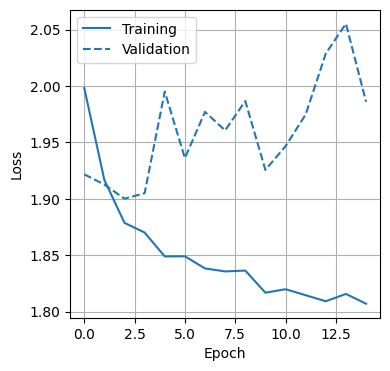

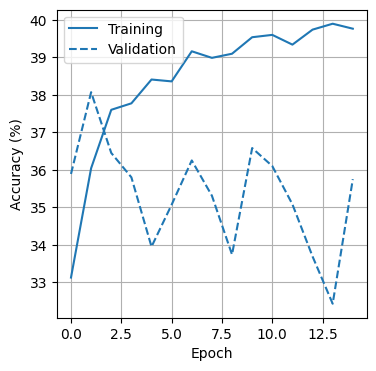

In [ ]:
plot_history(train_loss_history_softmax, val_loss_history_softmax, NUM_EPOCHS, "Loss")
plot_history(train_acc_history_softmax, val_acc_history_softmax, NUM_EPOCHS, "Accuracy (%)")

In [ ]:
test_acc_softmax = test_model(model, test_loader, DEVICE)

Test accuracy: 36.09%


36.09

## Fully Connected Neural Network

### Config

In [ ]:
NUM_EPOCHS = 15
LR = 5e-4

train_loader, val_loader, test_loader = create_data_loaders(INPUT_SIZE)

### Model

In [ ]:
from torch import nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_CHANNEL * INPUT_SIZE * INPUT_SIZE, 1024), nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, NUM_CLASSES)
)

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, INPUT_CHANNEL, INPUT_SIZE, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 3072]                 --
├─Linear: 1-2                            [1, 1024]                 3,146,752
├─ReLU: 1-3                              [1, 1024]                 --
├─Dropout: 1-4                           [1, 1024]                 --
├─Linear: 1-5                            [1, 512]                  524,800
├─ReLU: 1-6                              [1, 512]                  --
├─Dropout: 1-7                           [1, 512]                  --
├─Linear: 1-8                            [1, 256]                  131,328
├─ReLU: 1-9                              [1, 256]                  --
├─Dropout: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 128]                  32,896
├─ReLU: 1-12                             [1, 128]               

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_acc_history_fcnn, val_acc_history_fcnn, train_loss_history_fcnn, val_loss_history_fcnn, epoch_time_history_fcnn = train_model(
    model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

Epoch [1/15], Train loss: 1.7855, Train acc: 35.72%, Val loss: 1.6101, Val acc: 43.51%, Time: 10.50s
Epoch [2/15], Train loss: 1.5891, Train acc: 44.26%, Val loss: 1.4872, Val acc: 47.77%, Time: 11.08s
Epoch [3/15], Train loss: 1.4957, Train acc: 47.32%, Val loss: 1.4734, Val acc: 47.79%, Time: 11.80s
Epoch [4/15], Train loss: 1.4241, Train acc: 50.02%, Val loss: 1.4095, Val acc: 50.60%, Time: 11.28s
Epoch [5/15], Train loss: 1.3611, Train acc: 51.60%, Val loss: 1.4127, Val acc: 51.22%, Time: 11.56s
Epoch [6/15], Train loss: 1.3062, Train acc: 54.15%, Val loss: 1.3686, Val acc: 51.99%, Time: 11.45s
Epoch [7/15], Train loss: 1.2565, Train acc: 55.38%, Val loss: 1.3599, Val acc: 53.53%, Time: 11.40s
Epoch [8/15], Train loss: 1.2087, Train acc: 57.06%, Val loss: 1.3464, Val acc: 53.68%, Time: 11.63s
Epoch [9/15], Train loss: 1.1569, Train acc: 58.88%, Val loss: 1.3594, Val acc: 53.90%, Time: 11.51s
Epoch [10/15], Train loss: 1.1197, Train acc: 60.17%, Val loss: 1.3491, Val acc: 53.72%, Ti

### Evaluation

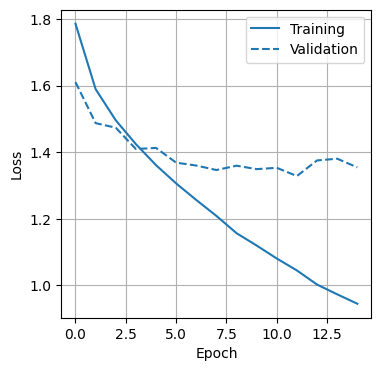

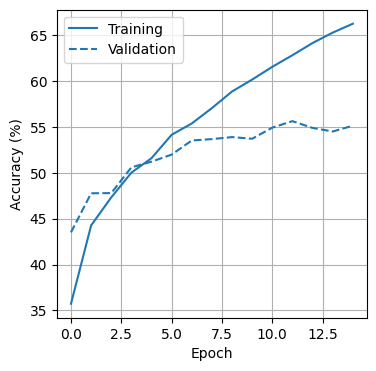

In [ ]:
plot_history(train_loss_history_fcnn, val_loss_history_fcnn, NUM_EPOCHS, "Loss")
plot_history(train_acc_history_fcnn, val_acc_history_fcnn, NUM_EPOCHS, "Accuracy (%)")

In [ ]:
test_acc_fcnn = test_model(model, test_loader, DEVICE)

Test accuracy: 54.87%


54.87

## AlexNet

### Config

In [ ]:
NUM_EPOCHS = 10
LR = 5e-4

ALEXNET_INPUT_SIZE = 224
train_loader, val_loader, test_loader = create_data_loaders(ALEXNET_INPUT_SIZE)

### Model

In [ ]:
from torch import nn

model = nn.Sequential(
    nn.Conv2d(INPUT_CHANNEL, 64, kernel_size=11, stride=4, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(256 * 6 * 6, 4096), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, NUM_CLASSES)
)

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, INPUT_CHANNEL, ALEXNET_INPUT_SIZE, ALEXNET_INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12                             [1, 256, 13, 13]    

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_acc_history_alexnet, val_acc_history_alexnet, train_loss_history_alexnet, val_loss_history_alexnet, epoch_time_history_alexnet = train_model(
    model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

Epoch [1/10], Train loss: 1.6166, Train acc: 40.03%, Val loss: 1.2559, Val acc: 54.61%, Time: 73.41s
Epoch [2/10], Train loss: 1.1489, Train acc: 59.21%, Val loss: 1.0594, Val acc: 62.88%, Time: 74.06s
Epoch [3/10], Train loss: 0.9373, Train acc: 67.23%, Val loss: 0.8983, Val acc: 68.68%, Time: 73.68s
Epoch [4/10], Train loss: 0.7862, Train acc: 72.83%, Val loss: 0.8123, Val acc: 71.86%, Time: 73.39s
Epoch [5/10], Train loss: 0.6675, Train acc: 76.88%, Val loss: 0.7984, Val acc: 72.64%, Time: 73.31s
Epoch [6/10], Train loss: 0.5701, Train acc: 80.45%, Val loss: 0.8488, Val acc: 72.17%, Time: 73.70s
Epoch [7/10], Train loss: 0.4640, Train acc: 83.77%, Val loss: 0.7935, Val acc: 74.15%, Time: 73.97s
Epoch [8/10], Train loss: 0.3977, Train acc: 86.25%, Val loss: 0.9478, Val acc: 73.77%, Time: 73.39s
Epoch [9/10], Train loss: 0.3376, Train acc: 88.37%, Val loss: 0.8732, Val acc: 73.29%, Time: 74.03s
Epoch [10/10], Train loss: 0.2958, Train acc: 89.89%, Val loss: 0.9475, Val acc: 74.06%, Ti

### Evaluation

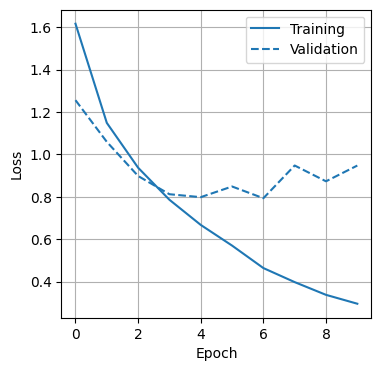

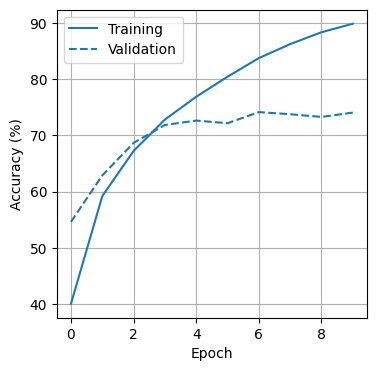

In [ ]:
plot_history(train_loss_history_alexnet, val_loss_history_alexnet, NUM_EPOCHS, "Loss")
plot_history(train_acc_history_alexnet, val_acc_history_alexnet, NUM_EPOCHS, "Accuracy (%)")

In [ ]:
test_acc_alexnet = test_model(model, test_loader, DEVICE)

Test accuracy: 73.76%


73.76

## ResNet

### Config

In [ ]:
NUM_EPOCHS = 10
LR = 5e-4

RESNET_INPUT_SIZE = 224
train_loader, val_loader, test_loader = create_data_loaders(RESNET_INPUT_SIZE)

### Model

In [ ]:
from torch import nn
import torch.nn.functional as F

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1_conv=False, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if use_1x1_conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
block1 = nn.Sequential(
    nn.Conv2d(INPUT_CHANNEL, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    residuals = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            residuals.append(Residual(in_channels, out_channels, use_1x1_conv=True, stride=2))
        else:
            residuals.append(Residual(out_channels, out_channels))
    return nn.Sequential(*residuals)

block2 = resnet_block(64, 64, 2, first_block=True)
block3 = resnet_block(64, 128, 2)
block4 = resnet_block(128, 256, 2)
block5 = resnet_block(256, 512, 2)

model = nn.Sequential(block1, block2, block3, block4, block5,
                      nn.AdaptiveAvgPool2d((1, 1)),
                      nn.Flatten(),
                      nn.Linear(512, NUM_CLASSES))

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, INPUT_CHANNEL, RESNET_INPUT_SIZE, RESNET_INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Residual: 2-5                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─Residual: 2-6                     [1, 64, 56, 56]           --
│

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_acc_history_resnet, val_acc_history_resnet, train_loss_history_resnet, val_loss_history_resnet, epoch_time_history_resnet = train_model(
    model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

Epoch [1/10], Train loss: 1.4599, Train acc: 46.38%, Val loss: 1.2161, Val acc: 57.52%, Time: 134.51s
Epoch [2/10], Train loss: 0.9219, Train acc: 67.54%, Val loss: 0.7546, Val acc: 73.06%, Time: 133.93s
Epoch [3/10], Train loss: 0.6564, Train acc: 77.47%, Val loss: 0.6892, Val acc: 75.29%, Time: 134.14s
Epoch [4/10], Train loss: 0.5036, Train acc: 82.57%, Val loss: 0.5498, Val acc: 80.93%, Time: 134.14s
Epoch [5/10], Train loss: 0.3904, Train acc: 86.39%, Val loss: 0.7552, Val acc: 75.35%, Time: 134.12s
Epoch [6/10], Train loss: 0.2835, Train acc: 90.17%, Val loss: 0.4970, Val acc: 83.39%, Time: 134.22s
Epoch [7/10], Train loss: 0.1952, Train acc: 93.27%, Val loss: 0.6094, Val acc: 81.15%, Time: 134.17s
Epoch [8/10], Train loss: 0.1309, Train acc: 95.50%, Val loss: 0.6766, Val acc: 81.55%, Time: 133.98s
Epoch [9/10], Train loss: 0.0985, Train acc: 96.65%, Val loss: 0.6126, Val acc: 83.30%, Time: 133.89s
Epoch [10/10], Train loss: 0.0782, Train acc: 97.28%, Val loss: 0.7340, Val acc: 8

### Evaluation

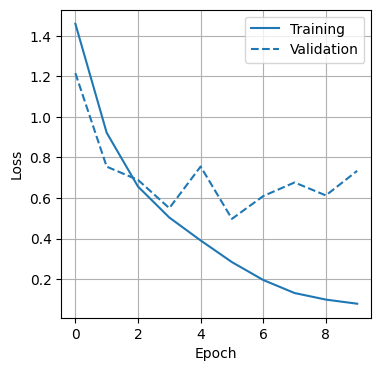

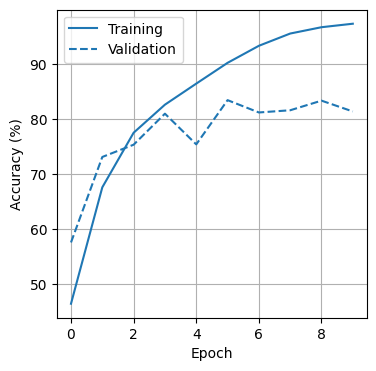

In [ ]:
plot_history(train_loss_history_resnet, val_loss_history_resnet, NUM_EPOCHS, "Loss")
plot_history(train_acc_history_resnet, val_acc_history_resnet, NUM_EPOCHS, "Accuracy (%)")

In [ ]:
test_acc_resnet = test_model(model, test_loader, DEVICE)

Test accuracy: 81.16%


81.16

## Vision Transformer

### Config

In [ ]:
NUM_EPOCHS = 10
LR = 5e-4
PATCH_SIZE = 16
EMB_SIZE = 256
NUM_HEADS = 4
MLP_RATIO = 4
NUM_LAYERS = 4
DROPOUT = 0.1

VIT_INPUT_SIZE = 224
train_loader, val_loader, test_loader = create_data_loaders(VIT_INPUT_SIZE)

### Model

In [ ]:
import torch
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)

    def forward(self, x):
        x = self.proj(x)  # (batch_size, emb_size, num_patches_h, num_patches_w)
        x = x.flatten(2)  # (batch_size, emb_size, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, emb_size)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, dropout=0.0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads

        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(emb_size, emb_size)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, num_patches, _ = x.shape
        qkv = self.qkv(x).reshape(batch_size, num_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, batch_size, num_heads, num_patches, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim**-0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(batch_size, num_patches, self.emb_size)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, emb_size=768, mlp_ratio=4, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, int(emb_size * mlp_ratio))
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(int(emb_size * mlp_ratio), emb_size)
        self.dropout2 = nn.Dropout(dropout)
        return

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, mlp_ratio=4, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = MLP(emb_size, mlp_ratio, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, num_heads=12, mlp_ratio=4, num_layers=12, num_classes=10, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.patch_embedding.num_patches + 1, emb_size))
        self.dropout = nn.Dropout(dropout)

        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(emb_size, num_heads, mlp_ratio, dropout) for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(emb_size)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding
        x = self.dropout(x)

        for block in self.encoder_blocks:
            x = block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]
        return self.fc(cls_token_final)

model = VisionTransformer(
    in_channels=INPUT_CHANNEL,
    patch_size=PATCH_SIZE,
    emb_size=EMB_SIZE,
    img_size=VIT_INPUT_SIZE,
    num_heads=NUM_HEADS,
    mlp_ratio=MLP_RATIO,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
)

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, INPUT_CHANNEL, VIT_INPUT_SIZE, VIT_INPUT_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 10]                   50,688
├─PatchEmbedding: 1-1                         [1, 196, 256]             --
│    └─Conv2d: 2-1                            [1, 256, 14, 14]          196,864
├─Dropout: 1-2                                [1, 197, 256]             --
├─ModuleList: 1-3                             --                        --
│    └─EncoderBlock: 2-2                      [1, 197, 256]             --
│    │    └─LayerNorm: 3-1                    [1, 197, 256]             512
│    │    └─MultiHeadSelfAttention: 3-2       [1, 197, 256]             263,168
│    │    └─LayerNorm: 3-3                    [1, 197, 256]             512
│    │    └─MLP: 3-4                          [1, 197, 256]             525,568
│    └─EncoderBlock: 2-3                      [1, 197, 256]             --
│    │    └─LayerNorm: 3-5                    [1, 197, 256]             51

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_acc_history_vit, val_acc_history_vit, train_loss_history_vit, val_loss_history_vit, epoch_time_history_vit = train_model(
    model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

Epoch [1/10], Train loss: 1.7634, Train acc: 34.28%, Val loss: 1.4998, Val acc: 44.80%, Time: 90.72s
Epoch [2/10], Train loss: 1.4552, Train acc: 46.75%, Val loss: 1.3868, Val acc: 50.04%, Time: 91.34s
Epoch [3/10], Train loss: 1.3305, Train acc: 51.62%, Val loss: 1.2507, Val acc: 54.32%, Time: 90.34s
Epoch [4/10], Train loss: 1.2535, Train acc: 54.52%, Val loss: 1.2136, Val acc: 56.05%, Time: 90.45s
Epoch [5/10], Train loss: 1.1772, Train acc: 57.46%, Val loss: 1.1218, Val acc: 59.61%, Time: 91.07s
Epoch [6/10], Train loss: 1.1097, Train acc: 59.90%, Val loss: 1.1531, Val acc: 58.85%, Time: 90.66s
Epoch [7/10], Train loss: 1.0569, Train acc: 62.04%, Val loss: 1.1178, Val acc: 60.56%, Time: 90.55s
Epoch [8/10], Train loss: 1.0069, Train acc: 63.83%, Val loss: 1.0109, Val acc: 64.03%, Time: 90.58s
Epoch [9/10], Train loss: 0.9595, Train acc: 65.48%, Val loss: 1.0574, Val acc: 63.51%, Time: 91.20s
Epoch [10/10], Train loss: 0.9123, Train acc: 67.21%, Val loss: 0.9911, Val acc: 64.63%, Ti

### Evaluation

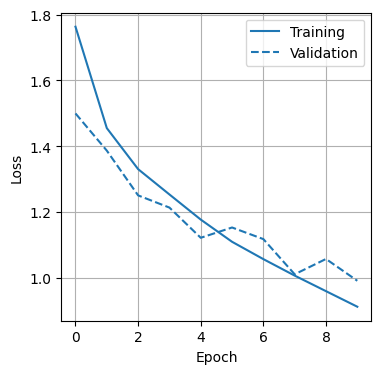

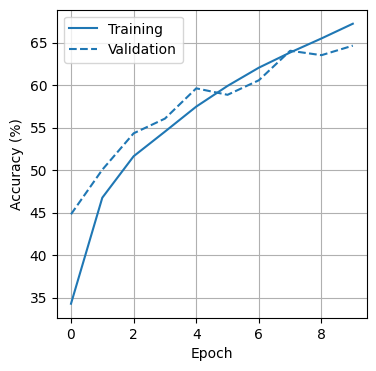

In [ ]:
plot_history(train_loss_history_vit, val_loss_history_vit, NUM_EPOCHS, "Loss")
plot_history(train_acc_history_vit, val_acc_history_vit, NUM_EPOCHS, "Accuracy (%)")

In [ ]:
test_acc_vit = test_model(model, test_loader, DEVICE)

Test accuracy: 64.55%


64.55

## Summary

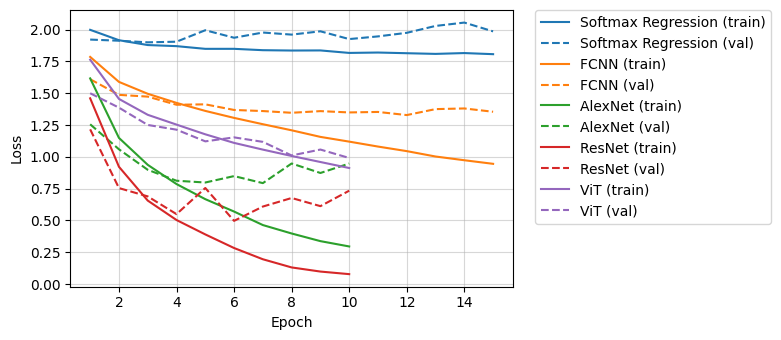

In [ ]:
import matplotlib.pyplot as plt

all_model_histories = [
    {
        'name': 'Softmax Regression',
        'train_loss': train_loss_history_softmax,
        'val_loss': val_loss_history_softmax,
        'train_acc': train_acc_history_softmax,
        'val_acc': val_acc_history_softmax,
    },
    {
        'name': 'FCNN',
        'train_loss': train_loss_history_fcnn,
        'val_loss': val_loss_history_fcnn,
        'train_acc': train_acc_history_fcnn,
        'val_acc': val_acc_history_fcnn,
    },
    {
        'name': 'AlexNet',
        'train_loss': train_loss_history_alexnet,
        'val_loss': val_loss_history_alexnet,
        'train_acc': train_acc_history_alexnet,
        'val_acc': val_acc_history_alexnet,
    },
    {
        'name': 'ResNet',
        'train_loss': train_loss_history_resnet,
        'val_loss': val_loss_history_resnet,
        'train_acc': train_acc_history_resnet,
        'val_acc': val_acc_history_resnet,
    },
    {
        'name': 'ViT',
        'train_loss': train_loss_history_vit,
        'val_loss': val_loss_history_vit,
        'train_acc': train_acc_history_vit,
        'val_acc': val_acc_history_vit,
    },
]

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

plt.figure(figsize=(8, 3.5))

for i, model_data in enumerate(all_model_histories):
    epochs = range(len(model_data['train_loss']))
    train_losses = model_data['train_loss']
    val_losses = model_data['val_loss']

    plt.plot(epochs, train_losses, color=colors[i], linestyle='-', label=f"{model_data['name']} (train)")
    plt.plot(epochs, val_losses, color=colors[i], linestyle='--', label=f"{model_data['name']} (val)")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

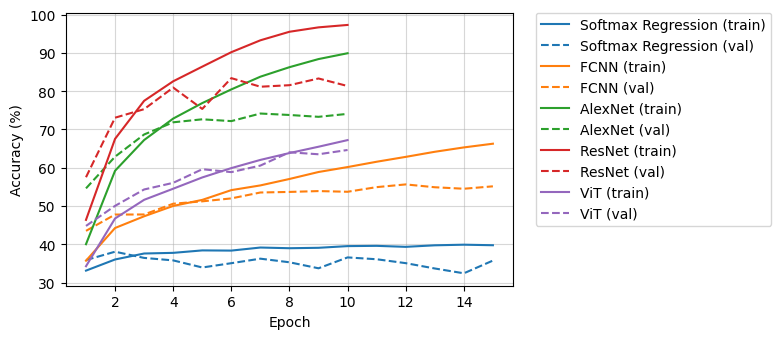

In [ ]:
plt.figure(figsize=(8, 3.5))

for i, model_data in enumerate(all_model_histories):
    epochs = range(len(model_data['train_acc']))
    train_accs = model_data['train_acc']
    val_accs = model_data['val_acc']

    plt.plot(epochs, train_accs, color=colors[i], linestyle='-', label=f"{model_data['name']} (train)")
    plt.plot(epochs, val_accs, color=colors[i], linestyle='--', label=f"{model_data['name']} (val)")

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from IPython.display import display

results = [
    {'Model': 'Softmax Regression', 'Test Accuracy (%)': test_acc_softmax, 'Avg Epoch Time (s)': sum(epoch_time_history_softmax) / len(epoch_time_history_softmax)},
    {'Model': 'FCNN', 'Test Accuracy (%)': test_acc_fcnn, 'Avg Epoch Time (s)': sum(epoch_time_history_fcnn) / len(epoch_time_history_fcnn)},
    {'Model': 'AlexNet', 'Test Accuracy (%)': test_acc_alexnet, 'Avg Epoch Time (s)': sum(epoch_time_history_alexnet) / len(epoch_time_history_alexnet)},
    {'Model': 'ResNet', 'Test Accuracy (%)': test_acc_resnet, 'Avg Epoch Time (s)': sum(epoch_time_history_resnet) / len(epoch_time_history_resnet)},
    {'Model': 'ViT', 'Test Accuracy (%)': test_acc_vit, 'Avg Epoch Time (s)': sum(epoch_time_history_vit) / len(epoch_time_history_vit)},
]

df = pd.DataFrame(results)
df = df.round(2)
print("Summary of Model Performance:")
display(df)

Summary of Model Performance:


,Model,Test Accuracy (%),Avg Epoch Time (s)
0,Softmax Regression,36.09,10.26
1,FCNN,54.87,11.41
2,AlexNet,73.76,73.67
3,ResNet,81.16,134.11
4,ViT,64.55,90.86
